In [ ]:
using Pkg
if isfile("../Project.toml") && isfile("../Manifest.toml")
    Pkg.activate("..");
    ENV["PYTHON"] = "python3";
end

using JuliaProbo
using Plots
gr();

In [ ]:
xlim = [-5.0, 5.0]
ylim = [-5.0, 5.0]
world = PuddleWorld(xlim, ylim)
push!(world, Puddle([-2.0, 0.0], [0.0, 2.0], 0.1))
push!(world, Puddle([-0.5, -2.0], [2.5, 1.0], 0.1))
sampling_num = 10
dp = DynamicProgramming([0.1, 0.1, pi/20], Goal(-3.0, -3.0), dt=0.1);
init_value(dp)
init_policy(dp)
init_state_transition_probs(dp, 0.1, sampling_num)
init_depth(dp, world, sampling_num)

In [ ]:
#=
Δ = 1e100
sweep_num = 0
while Δ > 0.01 && sweep_num < 300
    Δ = value_iteration_sweep(dp)
    sweep_num += 1
end
=#

In [ ]:
#=fd = open("policy.txt", "w")
for index in dp.indices
    v, ω = dp.policy_[index..., :]
    write(fd, "$(index[1]) $(index[2]) $(index[3]) $(v) $(ω)\n")
end
close(fd)
=#

┌ Info: Saved animation to 
│   fn = /home/mamoru/HOME/Programming/JuliaProbo/notebook/images/tmp.gif
└ @ Plots /home/mamoru/.julia/packages/Plots/uCh2y/src/animation.jl:104


Plots.AnimatedGif("/home/mamoru/HOME/Programming/JuliaProbo/notebook/images/tmp.gif")
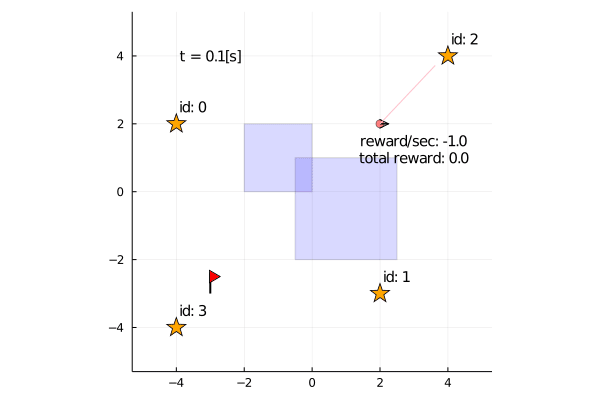

In [9]:
import JuliaProbo: init_policy, policy, decision, draw, PuddleIgnoreAgent
import Plots: Plot

mutable struct DpPolicyAgent <: AbstractAgent
    puddle_ignore_agent_::PuddleIgnoreAgent
    reso::Vector{Float64}
    pose_min::Vector{Float64}
    pose_max::Vector{Float64}
    index_nums::Vector{Int64}
    policy_data::AbstractArray{Float64,4}
end

function DpPolicyAgent(agent::PuddleIgnoreAgent, reso::Vector{Float64}; lowerleft = [-4.0, -4.0], upperright = [4.0, 4.0])
    pose_min = vcat(lowerleft, [0.0])
    pose_max = vcat(upperright, [2pi])
    index_nums = [convert(Int64, round((pose_max[i] - pose_min[i]) / reso[i])) for i = 1:3]
    policy_data = zeros(Float64, index_nums..., 2)
    fd = open("policy.txt", "r")
    lines = readlines(fd)
    for line in lines
        tokens = split(line, " ")
        tokens = map(x -> parse(Float64, x), tokens)
        id1, id2, id3 = map(x -> convert(Int64, x), tokens[1:3])
        v, ω = tokens[4], tokens[5]
        policy_data[id1, id2, id3, :] = [v, ω]
    end
    return DpPolicyAgent(agent, reso, pose_min, pose_max, index_nums, policy_data)
end

function policy(agent::DpPolicyAgent, pose::Vector{Float64}, goal = nothing)
    if agent.puddle_ignore_agent_.in_goal_
        return [0.0, 0.0]
    end
    reso = agent.reso
    pose_min = agent.pose_min
    index_nums = agent.index_nums
    index = [convert(Int64, round((pose[i] - pose_min[i]) / reso[i])) for i = 1:3]
    index[3] = (index[3] + 10*index_nums[3]) % index_nums[3]
    if index[3] == 0
        index[3] = index_nums[3]
    end
    for i in [1, 2]
        if index[i] < 0
            index[i] = 0
        end
        if index[i] > index_nums[i]
            index[i] = index_nums[i]
        end
    end
    return agent.policy_data[index..., :]
end

function draw(agent::DpPolicyAgent, p::Plot{T}) where {T}
    draw(agent.puddle_ignore_agent_, p)
end

function ch12_dp_mcl()
    dt = 0.1
    # environment
    xlim = [-5.0, 5.0]
    ylim = [-5.0, 5.0]
    # id of landmark must start from 0 with 1 step
    landmarks =
        [Landmark([-4.0, 2.0], 0), Landmark([2.0, -3.0], 1), Landmark([4.0, 4.0], 2),  Landmark([-4.0, -4.0], 3)]
    envmap = Map()
    push!(envmap, landmarks)
    world = PuddleWorld(xlim, ylim)
    push!(world, envmap)
    # goal
    goal = Goal(-3.0, -3.0)
    push!(world, goal)
    # robot side
    initial_pose = [2.0, 2.0, 0.0]
    estimator = KalmanFilter(envmap, initial_pose)
    agent = PuddleIgnoreAgent(0.2, 10.0 * pi / 180, dt, estimator, goal)
    reso = [0.1, 0.1, pi / 20]
    dp_agent = DpPolicyAgent(agent, reso)
    # robot = RealRobot(initial_pose, agent, RealCamera(landmarks, distance_bias_rate_stddev = 0.0, direction_bias_stddev = 0.0); color = "red")
    robot = RealRobot(initial_pose, agent, RealCamera(landmarks); color = "red")
    push!(world, robot)
    # puddles
    push!(world, Puddle([-2.0, 0.0], [0.0, 2.0], 0.1))
    push!(world, Puddle([-0.5, -2.0], [2.5, 1.0], 0.1))

    anim = @animate for i = 1:100
        t = dt * i
        annota = "t = $(round(t, sigdigits=3))[s]"
        # t
        update_status(world)
        z = observations(robot.sensor_, robot.pose_; noise = true, bias = true)
        p = draw(world, annota)
        
        # t+1
        v, ω = decision(agent, z)
        # v, ω = policy(dp_agent, agent.estimator_.pose_)
        state_transition(robot, v, ω, dt; move_noise = true, vel_bias_noise = true)
    end
    gif(anim, "images/tmp.gif", fps = 10)
    # gif(anim, "images/ch12_dp_mcl.gif", fps = 10)
end
ch12_dp_mcl()

<img src="images/ch12_dp_mcl.gif">